In [3]:
import time
import timeit

import pandas as pd
import numba as nb
import numpy as np

In [4]:
np.random.seed(23)

## 1. Скачивание и распаковка датасета

In [5]:
!mkdir dataset

In [6]:
!curl https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip --output dataset/data_original.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 75.1M    0  335k    0     0   231k      0  0:05:32  0:00:01  0:05:31  231k
  2 75.1M    2 2176k    0     0   888k      0  0:01:26  0:00:02  0:01:24  888k
  8 75.1M    8 6569k    0     0  1905k      0  0:00:40  0:00:03  0:00:37 1905k
 20 75.1M   20 15.3M    0     0  3534k      0  0:00:21  0:00:04  0:00:17 3535k
 35 75.1M   35 26.4M    0     0  4973k      0  0:00:15  0:00:05  0:00:10 6315k
 49 75.1M   49 37.0M    0     0  5854k      0  0:00:13  0:00:06  0:00:07 7473k
 64 75.1M   64 48.3M    0     0  6649k      0  0:00:11  0:00:07  0:00:04 9470k
 78 75.1M   78 59.2M    0     0  7186k      0  0:00:10  0:00:08  0:00:02 10.5M
 93 75.1M   93 70.4M    0     0  7631k      0  0:00

In [7]:
import zipfile

with zipfile.ZipFile("dataset/data_original.zip", mode="r") as archive:
    archive.extractall("dataset")

In [8]:
!del "dataset\data_original.zip"

## 2. Предобработка датасета

In [9]:
interactions = pd.read_csv('dataset/kion_train/interactions.csv')

interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'datetime',
        'total_dur': 'weight'
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [10]:
users = pd.read_csv('dataset/kion_train/users.csv')
items = pd.read_csv('dataset/kion_train/items.csv')

In [11]:
pd.concat([interactions.head(), interactions.tail()])

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [12]:
# Функция для генерации выборки
def generate_subsample(users_count: int, top_k: int, data: pd.DataFrame=interactions):
    users = np.random.choice(data['user_id'].unique(), users_count, replace=False)
    df = data[data['user_id'].isin(users)].reset_index(drop=True)
    del df['datetime'], df['weight'], df['watched_pct']
    
    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    return df, users, recs

## 3. MRR

## 3.1 Naive

In [13]:
def mrr_naive(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    mrr = []
    for i, user in enumerate(users):
        user_mrr = 0.0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr.append(user_mrr)
    return sum(mrr) / len(users)

## 3.2 Numba

In [14]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user_mrr = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr[i] = user_mrr
    return mrr.mean()

## 3.3 Pandas

In [15]:
def mrr_pandas(df_target: pd.DataFrame, users: np.ndarray, recs: np.ndarray):
    k = recs.shape[1]
    df_recs = pd.DataFrame({
        'user_id': np.repeat(users, k),
        'item_id': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df_target['target'] = 1
    df_recs = df_recs.merge(
        df_target,
        how='left',
        left_on=['user_id', 'item_id'],
        right_on=['user_id', 'item_id']
        )
    df_target.drop(['target'], axis=1, inplace=True)
    df_recs['reciprocal_rank'] = 0
    df_recs.loc[~df_recs['target'].isna(), 'reciprocal_rank'] = 1 / (df_recs.loc[~df_recs['target'].isna(), 'rank'])
    mrr = df_recs.groupby('user_id')['reciprocal_rank'].max().sum() / len(users)
    return mrr

In [16]:
# Тестируем что все функции возвращают одинаковые значения метрики

for top_k in [5, 10, 15]:
    for n_users in [100, 500, 1000, 10000]:
        for _ in range(10):
            df, users, recs = generate_subsample(n_users, top_k)
            target = df.values
            naive_mrr = mrr_naive(target, users, recs)
            nb_mrr = mrr_numba(target, users, recs)
            pd_mrr = mrr_pandas(df, users, recs)
            assert np.abs(naive_mrr - nb_mrr) < 1e-6, 'Naive and Numba calculations are not equal'
            assert np.abs(naive_mrr - pd_mrr) < 1e-6, 'Naive and Pandas calculations are not equal'
            assert np.abs(nb_mrr - pd_mrr) < 1e-6, 'Numba and Pandas calculations are not equal'
print(f'Everything seems fine!')

Everything seems fine!


## 4. Test evaulating time

In [17]:
users_counts = [100, 1000, 10000, 100000]
top_ks = [10, 50, 100]
n_runs = 10

In [18]:
avg_time_naive = np.zeros((len(users_counts), len(top_ks)))
avg_time_numba = np.zeros((len(users_counts), len(top_ks)))
avg_time_pandas = np.zeros((len(users_counts), len(top_ks)))

In [19]:
for i, user_count in enumerate(users_counts):
    for j, top_k in enumerate(top_ks):
        df, users, recs = generate_subsample(user_count, top_k)
        target = df.values
        
        print(f'Run naive user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('mrr_naive(target, users, recs)', "from __main__ import mrr_naive, target, users, recs" , number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_naive[i][j] = t / n_runs
              
        print(f'Run numba user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('mrr_numba(target, users, recs)', "from __main__ import mrr_numba, target, users, recs", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_numba[i][j] = t / n_runs
               
        print(f'Run pandas user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('mrr_pandas(df, users, recs)', "from __main__ import mrr_pandas, df, users, recs", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_pandas[i][j] = t / n_runs

Run naive user_count: 100, top_k: 10 for 10 times
Avg time: 0.0044 seconds
Run numba user_count: 100, top_k: 10 for 10 times
Avg time: 0.0002 seconds
Run pandas user_count: 100, top_k: 10 for 10 times
Avg time: 0.0087 seconds
Run naive user_count: 100, top_k: 50 for 10 times
Avg time: 0.0143 seconds
Run numba user_count: 100, top_k: 50 for 10 times
Avg time: 0.0003 seconds
Run pandas user_count: 100, top_k: 50 for 10 times
Avg time: 0.0102 seconds
Run naive user_count: 100, top_k: 100 for 10 times
Avg time: 0.0184 seconds
Run numba user_count: 100, top_k: 100 for 10 times
Avg time: 0.0002 seconds
Run pandas user_count: 100, top_k: 100 for 10 times
Avg time: 0.0116 seconds
Run naive user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0551 seconds
Run numba user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0045 seconds
Run pandas user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0118 seconds
Run naive user_count: 1000, top_k: 50 for 10 times
Avg time: 0.1494 seconds
Run numba user

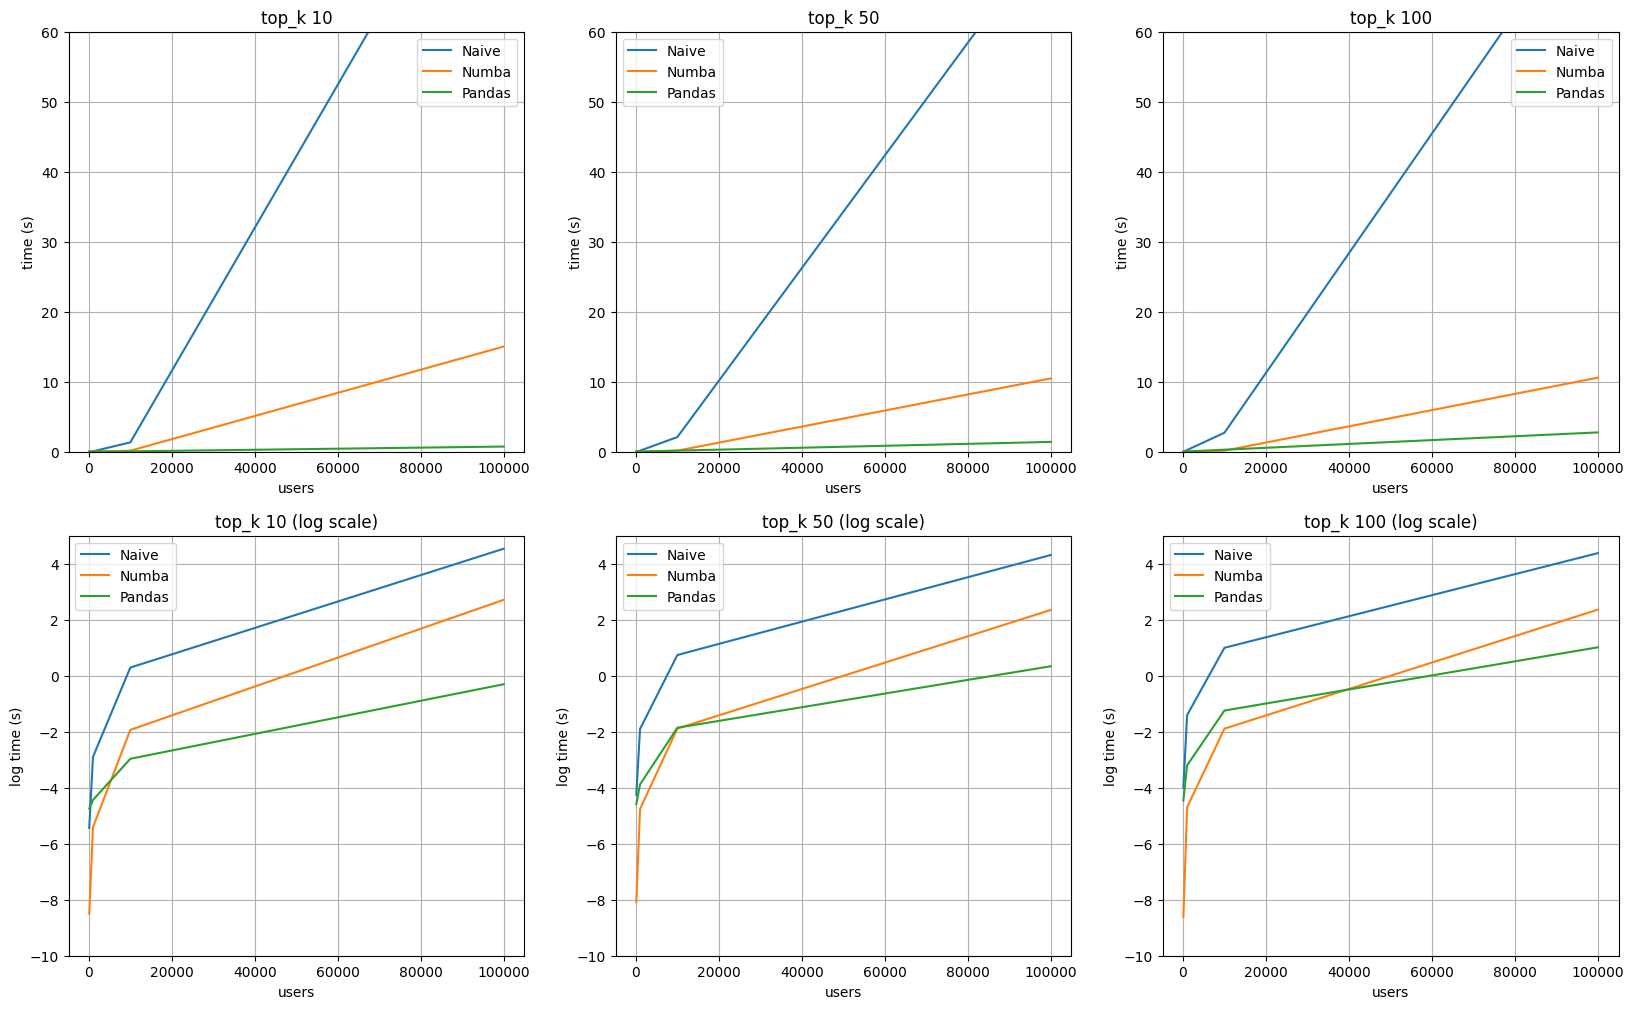

In [22]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(2, 3, figsize=(20, 12))
for i in range(3):
    ax[0][i].plot(users_counts, avg_time_naive[:, i], label='Naive')
    ax[0][i].plot(users_counts, avg_time_numba[:, i], label='Numba')
    ax[0][i].plot(users_counts, avg_time_pandas[:, i], label='Pandas')
    ax[0][i].set_title(f'top_k {top_ks[i]}')
    ax[0][i].set_xlabel('users')
    ax[0][i].set_ylabel('time (s)')
    ax[0][i].set_ylim(0, 60)
    ax[0][i].grid()
    ax[0][i].legend()
    
    # log scale
    ax[1][i].plot(users_counts, np.log(avg_time_naive[:, i]), label='Naive')
    ax[1][i].plot(users_counts, np.log(avg_time_numba[:, i]), label='Numba')
    ax[1][i].plot(users_counts, np.log(avg_time_pandas[:, i]), label='Pandas')
    ax[1][i].set_title(f'top_k {top_ks[i]} (log scale)')
    ax[1][i].set_xlabel('users')
    ax[1][i].set_ylabel('log time (s)')
    ax[1][i].set_ylim(-10, 5)
    ax[1][i].grid()
    ax[1][i].legend()
plt.show()

По графикам наглядно видно преимущество использования pandas над всеми реализациями и быстрый и резкий рост времени выполнения для naive подхода.

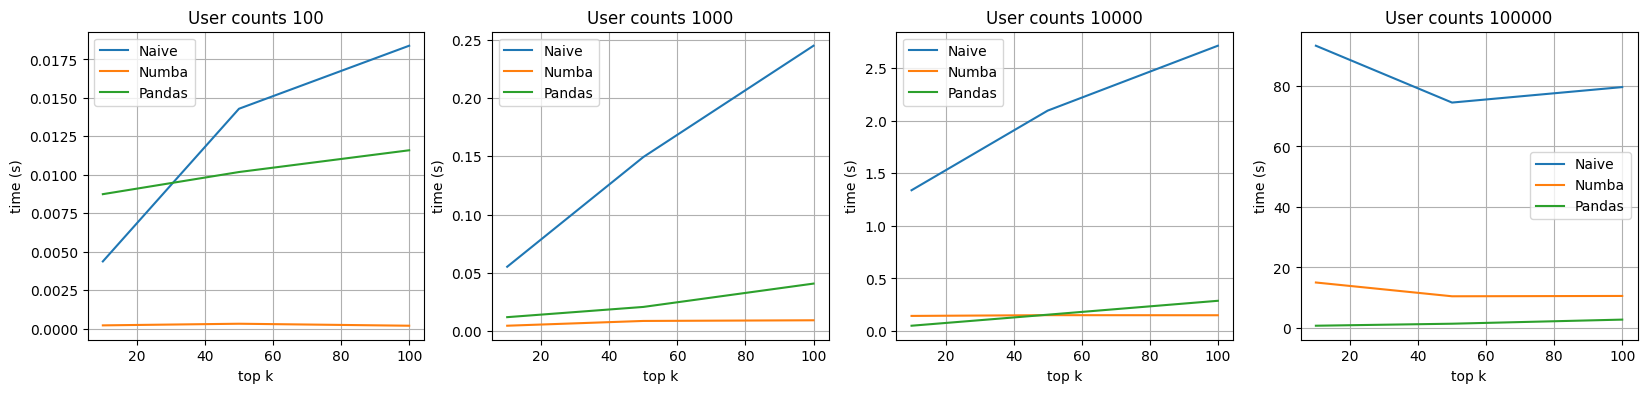

In [23]:
_, ax = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
    ax[i].plot(top_ks, avg_time_naive[i, :], label='Naive')
    ax[i].plot(top_ks, avg_time_numba[i, :], label='Numba')
    ax[i].plot(top_ks, avg_time_pandas[i, :], label='Pandas')
    ax[i].set_title(f'User counts {users_counts[i]}')
    ax[i].grid()
    ax[i].set_xlabel('top k')
    ax[i].set_ylabel('time (s)')
    ax[i].legend()
plt.show()